# Artificial Intelligence
# 464/664
# Assignment #6

## General Directions for this Assignment

00. We're using a Jupyter Notebook environment (tutorial available here: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html),
01. Read the entire notebook before beginning your work, 
02. Output format should be exactly as requested (it is your responsibility to make sure notebook looks as expected on Gradescope),
03. Each helper function should be preceeded by documentation (Markdown cell),
04. No comments in the code; anything worth mentioning should be included in the documentation,
05. Use descriptive variable names,
06. Functions should do only one thing,
07. Check submission deadline on Gradescope, 
08. Rename the file to Last_First_assignment_6, 
09. Submit your notebook (as .ipynb, not PDF) using Gradescope, 
10. Do not submit any other files, and
11. **Do not use any AI/ML libraries, packages, such as pandas, scikit (numpy is fine)**

## Directions _not_ applicable for this Assignment:
* Do not use classes,
* Keep functions to 20 lines or less (including empty lines so do not add any),
* Each helper function should be followed by three assert-style unit tests.

## Before You Submit...

1. Re-read the general instructions provided above, and
2. Hit "Kernel"->"Restart & Run All".

## Decision Trees

For this assignment we will implement a Decision Tree using the ID3 Algorithm. The goal is classify a mushroom as either edible ('e') or poisonous ('p'). Dataset has been uploaded to Canvas. In case you'd like to learn more about it, here's the link to the repo: https://archive.ics.uci.edu/dataset/73/mushroom. 


Our  Decision Tree pipeline is as follows:


1) `cross_validate` will take data (supplied as folds using 10 fold cross validation) and do the following:
* For each setting of depth limit (the hyperparameter in decision trees, including 0)
* * and for each fold of data
* * * use `create_train_test` to split current fold into train and test
* * * call `train` to build and return a decision tree, 
* * * call `classify` to use the tree to get classifications,
* * * call `evaluate` to compare classifications to the actual answers (ground truth),
* * * Print the performance for that fold
* * Summarize the performance for that depth limit over all folds using `get_stats`


2) `pretty_print_tree(tree)` will print what the tree looks like when using the **entire** data set (no train/test split) with depth limit set to None.


All the code in this pipeline has been provided, except for a working `train` function. The `train` function currently returns a hard-coded tree from our lecture. Don't do that. Use ID3 to build your tree and use the depth limit to stop. When you're train function is complete, it should work for the lecture data, and mushrooms. Although `train` is terrible right now, pay attention to how the tree is structured.

In [1]:
import random
import math
import copy
from copy import deepcopy
from typing import List, Dict, Tuple, Callable
from collections import Counter, defaultdict

<a id="note"></a>

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>
        Let's start with our example from the 06-Nov lecture. Target variable is Safe?, which can be yes or no. Anything *_lecture refers to the dataset we walked through in class.  
    </p>
</div>

In [2]:
data_lecture = [['round','large','blue','no'],
['square','large','green','yes'],
['square','small','red','no'],
['round','large','red','yes'],
['square','small','blue','no'],
['round','small','blue','no'],
['round','small','red','yes'],
['square','small','green','no'],
['round','large','green','yes'],
['square','large','green','yes'],
['square','large','red','no'],
['square','large','green','yes'],
['round','large','red','yes'],
['square','small','red','no'],
['round','small','green','no']]

In [3]:
print(data_lecture[0]) # a record of data

['round', 'large', 'blue', 'no']


In [4]:
len(data_lecture)

15

In [5]:
attribute_names_lecture = ['shape', 
                      'size', 
                      'color']

<a id="create_folds"></a>
## create_folds


With n-fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. For data set with 100 observations (or records), n set to 10 would have 10 observations in each fold.

* **data** List: a list (data_lecture, for instance)
* **n** int: number of folds


**returns** 
folds, which is a list of n items, where each item is a list containing a subgroup of xs

In [6]:
def create_folds(data: List, n: int) -> List[List[List]]:
    k, m = divmod(len(data), n)
    return list(data[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [7]:
folds_lecture = create_folds(data=data_lecture, n=10)

In [8]:
len(folds_lecture)

10

In [9]:
print(folds_lecture[0])

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes']]


In [10]:
print(folds_lecture[1])

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes']]


<a id="create_train_test"></a>
## create_train_test


This function takes the n folds and returns the train and test sets. One of the n folds is used to test, the others are used for training.

* **folds** List[List[List]]: see `create_folds`
* **index** int: fold index that is used for testing


**returns** 
folds, which is a list of n items, where each item is a list containing a subgroup of xs

In [11]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

In [12]:
train_lecture, test_lecture = create_train_test(folds_lecture, 0) # test data is folds_lecture index 0

In [13]:
print(train_lecture)

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'blue', 'no'], ['round', 'small', 'blue', 'no'], ['round', 'small', 'red', 'yes'], ['square', 'small', 'green', 'no'], ['round', 'large', 'green', 'yes'], ['square', 'large', 'green', 'yes'], ['square', 'large', 'red', 'no'], ['square', 'large', 'green', 'yes'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'red', 'no'], ['round', 'small', 'green', 'no']]


In [14]:
print(test_lecture)

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes']]


In [15]:
train_lecture, test_lecture = create_train_test(folds_lecture, 1) # test data is folds_lecture index 1

In [16]:
print(train_lecture)

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes'], ['square', 'small', 'blue', 'no'], ['round', 'small', 'blue', 'no'], ['round', 'small', 'red', 'yes'], ['square', 'small', 'green', 'no'], ['round', 'large', 'green', 'yes'], ['square', 'large', 'green', 'yes'], ['square', 'large', 'red', 'no'], ['square', 'large', 'green', 'yes'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'red', 'no'], ['round', 'small', 'green', 'no']]


In [17]:
print(test_lecture)

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes']]


<a id="note"></a>

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's load the mushroom data.
    </p>
</div>

<a id="parse_data"></a>
## parse_data

Opens a file, splits on comma, and shuffles data before returning as a List of list. 

* **file_name** Str: filename for data


**returns** 
Data as a list of a list.

In [18]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [value for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [19]:
data_mushroom = parse_data("agaricus-lepiota.data")

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Important</strong>
    <p>
        We're going to move the target column (mushroom edible or poisonous) to the last column to match the lecture's format, where Safe? was at the end.
    </p>
</div>

In [20]:
data_mushroom = [record[1:]+[record[0]] for record in data_mushroom]

In [21]:
len(data_mushroom)

8124

In [22]:
print(data_mushroom[0])

['x', 'f', 'n', 'f', 'n', 'f', 'w', 'b', 'p', 't', 'e', 's', 'f', 'w', 'w', 'p', 'w', 'o', 'e', 'n', 'a', 'g', 'e']


In [23]:
attribute_names_mushroom = ['cap-shape',
                   'cap-surface',
                   'cap-color',
                   'bruises?',
                   'odor',
                   'gill-attachment',
                   'gill-spacing',
                   'gill-size',
                   'gill-color',
                   'stalk-shape',
                   'stalk-root',
                   'stalk-surface-above-ring',
                   'stalk-surface-below-ring',
                   'stalk-color-above-ring',
                   'stalk-color-below-ring',
                   'veil-type',
                   'veil-color',
                   'ring-number',
                   'ring-type',
                   'spore-print-color',
                   'population',
                   'habitat']

<a id="get_answers"></a>
## get_answers

This function extracts a list of the target values from data. The function assumes the target variable is the last column of the data.

* **data** List[List]: The data provided in a list of list format identical to the structure of `data_lecture` or `data_mushroom`


**returns** 
A list of the values of the target variable.

In [24]:
def get_answers(data):
    return [record[-1] for record in data]

In [25]:
assert get_answers([]) == []
assert get_answers(data_lecture) == ['no', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no']

<a id="get_mode"></a>
## get_mode

This function finds the mode of a list of items. 

* **answers** List: A list of items

**returns** 
The item that appears the most often in the list. 

In [26]:
def get_mode(answers):
    count_dict = {}
    for answer in answers:
        if answer in count_dict:
            count_dict[answer] = count_dict[answer] + 1
        else:
            count_dict[answer] = 1
    mode_count = max(count_dict.values())
    mode = [k for k, v in count_dict.items() if v == mode_count]
    return mode[0]

In [27]:
assert get_mode(['no', 'no', 'no', 'yes']) == 'no'
assert get_mode(['no', 'no', 'yes', 'yes']) == 'no'
assert get_mode(['no', 'yes', 'yes', 'yes']) == 'yes'

<a id="train"></a>
## train

This function takes training_data, attribute names, and the depth limit and returns the decision tree as a nested dictionary. If the depth is 0, a dictionary is not returned. Instead, the mode of the target values is returned (i.e., majority class). 

* **training_data** List[List]: The data
* **attribute_names** List: The attribute names of the data (22 for mushroom; size, shape, and color for the lecture)
* **depth_limit** int: The depth limit of the tree


**returns** 
* **dt** Dict: The trained decision tree using the ID3 algorithm (entropy, information gain). It is represented as a nested dictionary. The dictionary returned for the lecture is structured as below:

```
{
('size', 1, 'large'): 
    {('color', 2, 'blue'): 'no', 
     ('color', 2, 'green'): 'yes', 
     ('color', 2, 'red'): 
         {('shape', 0, 'round'): 'yes', 
          ('shape', 0, 'square'): 'no'}
     }, 
('size', 1, 'small'): 
     {('shape', 0, 'square'): 'no', 
      ('shape', 0, 'round'): 
          {('color', 2, 'blue'): 'no', 
           ('color', 2, 'red'): 'yes', 
           ('color', 2, 'green'): 'no'}
      }
}
```


Notice that the keys are tuples; for instance, ('size', 1, 'large') is a key. The key includes the attribute's name, column number in data, and value.


The function currently returns a hard-coded tree. Your implementation should replace this with a tree that is learned from the data using the ID3 algorithm. You do not have to assert test `train`, but it may be worthwhile to check that it can return the tree from the lecture once your implementation is in place.

## calculate_entropy

Calculates the entropy of a given 2D list, according to formula: $$H(X) = -\sum_{i=1}^{n} p(x_i) \log_2 p(x_i)$$

* **data** List[List]: The data to calculate the entropy of

**returns**

- **entropy** float: The entropy of the data




In [28]:
def calculate_entropy(data):
    if not data: return 0
    targets = [row[-1] for row in data]
    counts = Counter(targets)
    entropy = 0
    for count in counts.values():
        p = count / len(targets)
        entropy -= p * math.log2(p)
    return entropy

## calculate_information_gain

Splits the given data set on the given attribute X_idx. For every unique value at column X_idx, a new 2D list is created with rows with that value at X_idx. The function then sums all the entropies of the resulting 2D lists.

* **data** List[List]: The data to calculate the information gain of
* **X_idx** int: The index of the attribute to split the data on

**returns**

- **information_gain** float: The "information gain" of the data, i.e. the reduction in entropy achieved by splitting on the given attribute


In [29]:
def calculate_information_gain(data, X_idx):
    initial_entropy = calculate_entropy(data)
    attribute_groups = defaultdict(list)
    for row in data:
        attribute_groups[row[X_idx]].append(row)
    next_entropy = sum(calculate_entropy(group) for group in attribute_groups.values())
    return initial_entropy - next_entropy

## find_best_attribute

Finds the attribute, defined as the attribute that will result in the most information gain, if the data is split on that attribute.

* **data** List[List]: The data to find the best attribute of
* **attribute_names** List: The attribute names of the data
* **used_attributes** Set: The attributes that have already been used

**returns**

- **best_attribute** str: The attribute with the highest information gain
- **best_idx** int: The index of the attribute with the highest information gain


In [30]:
def find_best_attribute(data, attribute_names, used_attributes):
    best_gain = -1
    best_attribute = None
    best_idx = None
    for idx, attr in enumerate(attribute_names):
        if idx in used_attributes: continue
        gain = calculate_information_gain(data, idx)
        if gain > best_gain:
            best_gain = gain
            best_attribute = attr
            best_idx = idx
    return best_attribute, best_idx

## train

This function builds a decision tree using the ID3 algorithm — recursively selecting the "best" attribute to split on at each step, using information gain as the criterion.

* **training_data** List[List]: The data to build the tree on
* **attribute_names** List: The attribute names of the data
* **depth_limit** int: The depth limit of the tree

**returns**

- **tree** Dict: The decision tree as a nested dictionary

In [31]:
def train(training_data, attribute_names, depth_limit=None):
    def id3(data, attributes_used, depth=0):
        targets = [row[-1] for row in data]
        if len(set(targets)) == 1:
            return targets[0]
        if len(attributes_used) == len(attribute_names) or (depth_limit is not None and depth >= depth_limit):
            return get_mode(targets)
        best_attr, best_idx = find_best_attribute(data, attribute_names, attributes_used)
        if best_attr is None:
            return get_mode(targets)
        tree = {}
        attributes_used.add(best_idx)
        value_groups = {}
        for row in data:
            value = row[best_idx]
            if value not in value_groups:
                value_groups[value] = []
            value_groups[value].append(row)
        for value, group in value_groups.items():
            key = (best_attr, best_idx, value)
            tree[key] = id3(group, attributes_used.copy(), depth + 1)
        return tree
    return id3(training_data, set(), 0)

In [32]:
dt_lecture = train(training_data=train_lecture, attribute_names=attribute_names_lecture, depth_limit=0)

<a id="get_prediction"></a>
## get_prediction

This recursive function uses a decision tree represented as a nested dictionary get a prediction from a record, which is a row of the data. 

* **record** List[]: A row of data to be predicted
* **dt** the decision tree used to make the prediction


**returns** 
A prediction ('yes' or 'no' for instance, from our Self Check example.) 

In [33]:
def get_prediction(record, dt):
    if not isinstance(dt, dict):
        return dt
    else:
        for key, value in dt.items():
            if record[key[1]]==key[2]:
                return get_prediction(record, value)

In [34]:
print(get_prediction(['round','large','blue','no'], dt=dt_lecture))
print(get_prediction(['square','large','green','yes'], dt=dt_lecture))
print(get_prediction(['square','small','red','no'], dt=dt_lecture))

no
no
no


<a id="classify"></a>
## classify

This function takes a decision tree, observations, and a labeled flag to return a list of classifications. 

* **dt** Dict: The decision tree as a nested dictionary
* **observation** List[List]: a list of items, where each item is a row of the data
* **labeled** Bool: true for labeled data


**returns** 
* **y_hat** List: A list of classifications.

In [35]:
def classify(dt, observations):
    y_hat = []
    for record in observations:
        y_hat.append(get_prediction(record, dt))   
    return y_hat

In [36]:
print(classify(dt=dt_lecture, observations=test_lecture))

['no', 'no']


<a id="evaluate"></a>
## evaluate

This function evaluates the performance of a classifier. It takes a data set (training set or test set) and the classification result (see [classify](#classify) above and calculates the classification error rate:

$$error\_rate=\frac{errors}{n}$$ 

* **y_hat** List: A list of predictions
* **observations** List[List]: Data to be predicted (typically training or test set)


**returns** 

* **error_rate** float: The error rate.

In [37]:
def evaluate(y_hat, observations):
    errors = 0
    ground_truth = get_answers(observations)
    for index in range(len(y_hat)):
        if y_hat[index] != ground_truth[index]:
            errors = errors + 1
    return errors / (len(y_hat))

In [38]:
print(evaluate(classify(dt=dt_lecture, observations=data_lecture), observations=data_lecture))

0.4666666666666667


<a id="get_stats"></a>
## get_stats

This function computes the mean and the standard deviation for a given list of observations. 

* **observations** List[float]: A list of observations


**returns** (mean, standard deviation) Tuple[float,float]: tuple consisting of mean and the standard deviation

In [39]:
def get_stats(observations: List[float]) -> Tuple[float,float]:
    mean = sum(observations) / len(observations)
    variance = sum([(elem - mean)**2 for elem in observations]) / len(observations)
    std_dev = math.sqrt(variance)
    return mean, std_dev

In [40]:
assert get_stats([2, 4, 4, 4, 5, 5, 7, 9]) == (5.0, 2.0)
assert get_stats([1, 1, 1]) == (1.0, 0.0)
assert get_stats([0]) == (0.0, 0.0)

<a id="cross_validate"></a>
## cross_validate

This function takes folds of data to `train`, `classify`, and `evaluate`.


* **folds** List[List[List]]: The original dataset partitioned into folds (see `create_folds` above)
* **attribute_names** int: the feature names
* **hyperparameters** List: A list of hyperparameters to explore (depth limits for a decision tree, for instance)

**returns** 

Nothing is returned, but for each hyperparameter setting, the function prints out the fold number and the error rate for that fold. The mean and variance is printed across folds for each hyperparameter setting. The error rates are reported in terms of percents.

In [41]:
def cross_validate(folds, attribute_names, hyperparameters):
    for hyperparameter in hyperparameters:
        train_error, test_error  = [], []
        error_list_train, error_list_test = [], []
        for fold_index in range(len(folds)):
            training_data, test_data = create_train_test(folds, fold_index)
            tree = train(training_data=training_data, attribute_names=attribute_names, depth_limit=hyperparameter)
            y_hat_train = classify(tree, training_data)
            y_hat_test = classify(tree, test_data)
            error_rate_train = evaluate(y_hat_train, training_data)
            error_rate_test = evaluate(y_hat_test, test_data)
            error_list_train.append(error_rate_train)
            error_list_test.append(error_rate_test)
            print(f"Fold: {fold_index}\tTrain Error: {error_rate_train*100:.2f}%\tTest Error: {error_rate_test*100:.2f}%")
        print(f"***")
        print(f"Depth limit: {hyperparameter}")
        print(f"\nMean(Std. Dev.) over all folds:\n-------------------------------")
        print(f"Train Error: {get_stats(error_list_train)[0]*100:.2f}%({get_stats(error_list_train)[1]*100:.2f}%) Test Error: {get_stats(error_list_test)[0]*100:.2f}%({get_stats(error_list_test)[1]*100:.2f}%)")
        print("\n")

In [42]:
cross_validate(folds=folds_lecture, attribute_names=attribute_names_lecture, hyperparameters=[0, 1, 2, 3, 4, 5, None])

Fold: 0	Train Error: 46.15%	Test Error: 50.00%
Fold: 1	Train Error: 46.15%	Test Error: 50.00%
Fold: 2	Train Error: 46.15%	Test Error: 100.00%
Fold: 3	Train Error: 46.15%	Test Error: 50.00%
Fold: 4	Train Error: 38.46%	Test Error: 100.00%
Fold: 5	Train Error: 50.00%	Test Error: 0.00%
Fold: 6	Train Error: 42.86%	Test Error: 100.00%
Fold: 7	Train Error: 42.86%	Test Error: 100.00%
Fold: 8	Train Error: 50.00%	Test Error: 0.00%
Fold: 9	Train Error: 50.00%	Test Error: 0.00%
***
Depth limit: 0

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 45.88%(3.53%) Test Error: 55.00%(41.53%)


Fold: 0	Train Error: 15.38%	Test Error: 50.00%
Fold: 1	Train Error: 23.08%	Test Error: 0.00%
Fold: 2	Train Error: 23.08%	Test Error: 0.00%
Fold: 3	Train Error: 15.38%	Test Error: 50.00%
Fold: 4	Train Error: 23.08%	Test Error: 0.00%
Fold: 5	Train Error: 14.29%	Test Error: 100.00%
Fold: 6	Train Error: 21.43%	Test Error: 0.00%
Fold: 7	Train Error: 21.43%	Test Error: 0.00%
Fold: 8	Train Err

<a id="pretty_print_tree"></a>
## pretty_print_tree

This function provides a text-based representation of a decision tree that is represented as a nested dictionary. 

* **dt** Dict: The decision tree as a nested dictionary
* **tab_space** Int: How much to tab successive depth levels of the resulting tree

In [43]:
def pretty_print_tree(dt, tab_space):
    for key, value in dt.items():
        if isinstance(value, dict):
            print("  " * tab_space + str(key[0]).upper() + " - " + str(key[2]) + ": ")
            print("\n")
            pretty_print_tree(value, tab_space+3)
        else:
            print("  " * tab_space + str(key[0]).upper() + " - " + str(key[2]) + " =====> " + str(value))
            print("\n")

In [44]:
dt_lecture = train(training_data=data_lecture, attribute_names=attribute_names_lecture, depth_limit=None)
pretty_print_tree(dt_lecture, tab_space=0)

SIZE - large: 


      COLOR - blue =====> no


      COLOR - green =====> yes


      COLOR - red: 


            SHAPE - round =====> yes


            SHAPE - square =====> no


SIZE - small: 


      SHAPE - square =====> no


      SHAPE - round: 


            COLOR - blue =====> no


            COLOR - red =====> yes


            COLOR - green =====> no




<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's work on the mushroom data. 
    </p>
</div>

## Classify the Mushrooom data

In [45]:
folds_mushroom = create_folds(data=data_mushroom, n=10)

In [46]:
cross_validate(folds=folds_mushroom, attribute_names=attribute_names_mushroom, hyperparameters=[0, 1, 2, 3, 4, 5, None])

Fold: 0	Train Error: 48.12%	Test Error: 48.95%
Fold: 1	Train Error: 48.35%	Test Error: 46.86%
Fold: 2	Train Error: 47.91%	Test Error: 50.80%
Fold: 3	Train Error: 48.26%	Test Error: 47.72%
Fold: 4	Train Error: 48.22%	Test Error: 48.03%
Fold: 5	Train Error: 47.98%	Test Error: 50.25%
Fold: 6	Train Error: 48.36%	Test Error: 46.80%
Fold: 7	Train Error: 48.32%	Test Error: 47.17%
Fold: 8	Train Error: 48.19%	Test Error: 48.28%
Fold: 9	Train Error: 48.32%	Test Error: 47.17%
***
Depth limit: 0

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 48.20%(0.15%) Test Error: 48.20%(1.33%)


Fold: 0	Train Error: 1.45%	Test Error: 1.72%
Fold: 1	Train Error: 1.50%	Test Error: 1.23%
Fold: 2	Train Error: 1.57%	Test Error: 0.62%


Fold: 3	Train Error: 1.40%	Test Error: 2.21%
Fold: 4	Train Error: 1.49%	Test Error: 1.35%
Fold: 5	Train Error: 1.45%	Test Error: 1.72%
Fold: 6	Train Error: 1.50%	Test Error: 1.23%
Fold: 7	Train Error: 1.44%	Test Error: 1.85%
Fold: 8	Train Error: 1.49%	Test Error: 1.35%
Fold: 9	Train Error: 1.48%	Test Error: 1.48%
***
Depth limit: 1

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 1.48%(0.05%) Test Error: 1.48%(0.41%)


Fold: 0	Train Error: 1.34%	Test Error: 1.72%
Fold: 1	Train Error: 1.41%	Test Error: 1.11%
Fold: 2	Train Error: 1.46%	Test Error: 0.62%
Fold: 3	Train Error: 1.31%	Test Error: 1.97%
Fold: 4	Train Error: 1.38%	Test Error: 1.35%
Fold: 5	Train Error: 1.45%	Test Error: 1.72%
Fold: 6	Train Error: 1.50%	Test Error: 1.23%
Fold: 7	Train Error: 1.34%	Test Error: 1.72%
Fold: 8	Train Error: 1.38%	Test Error: 1.35%
Fold: 9	Train Error: 1.37%	Test Error: 1.48%
***
Depth limit: 2

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 1

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's work on the mushroom data. 
    </p>
</div>

## Print the Mushroom Tree

In [47]:
dt_mushroom = train(training_data=data_mushroom, attribute_names=attribute_names_mushroom, depth_limit=None)
pretty_print_tree(dt_mushroom, tab_space=0)

ODOR - n: 


      VEIL-COLOR - w: 


            GILL-ATTACHMENT - f: 


                  VEIL-TYPE - p: 


                        STALK-COLOR-ABOVE-RING - w: 


                              STALK-SURFACE-BELOW-RING - f =====> e


                              STALK-SURFACE-BELOW-RING - s: 


                                    SPORE-PRINT-COLOR - w: 


                                          STALK-SHAPE - e: 


                                                STALK-COLOR-BELOW-RING - w: 


                                                      GILL-SIZE - b =====> e


                                                      GILL-SIZE - n =====> p


                                                STALK-COLOR-BELOW-RING - e =====> e


                                                STALK-COLOR-BELOW-RING - n =====> e


                                    SPORE-PRINT-COLOR - k =====> e


                                    SPORE-PRINT-COLOR - n =====> e


                               

## OPTIONAL. BONUS. 

Use an AI/ML library to build a decision tree for the mushroom dataset. Explore different depth limits. Print results. Display the best tree using your chosen library.  

In [48]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## load_mushroom_data

Loads the mushroom data from a file and returns a pandas DataFrame.

* **filepath** str: The path to the mushroom data file

**returns**

- **df** pandas.DataFrame: The mushroom data as a pandas DataFrame


In [49]:
def load_mushroom_data(filepath='agaricus-lepiota.data'):
  columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
              'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
              'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
              'stalk-surface-below-ring', 'stalk-color-above-ring',
              'stalk-color-below-ring', 'veil-type', 'veil-color',
              'ring-number', 'ring-type', 'spore-print-color',
              'population', 'habitat']
  
  df = pd.read_csv(filepath, names=columns)
  return df

## prepare_data

Prepare the data for modeling: do a one-hot encoding (turning 1D categorical data into 2D list of binary data) on the dataframe after removing the target variable (class column).

* **df** pandas.DataFrame: The mushroom data as a pandas DataFrame

**returns**

- **X** pandas.DataFrame: The features, aftering being one-hot encoded
- **y** pandas.Series: The target variable in integer form (0 = poisonous, 1 = edible)

In [50]:
def prepare_data(df):
  features_df = df.drop('class', axis=1)
  x = pd.get_dummies(features_df)
  y = (df['class'] == 'e').astype(int)
  return x, y

## Met (enum type)

Model metrics enum type, to make sure we don't mis-spell any attributes.

In [51]:
from enum import Enum

class Met(str, Enum):
  TRAIN_SCORE = 'train_score'
  TEST_SCORE = 'test_score'
  MODEL = 'model'

## evaluate_depths

Trains and evaluates the performance of a decision tree classifier for different depth limits, using DecisionTreeClassifier (from sklearn).

* **X_train** pandas.DataFrame: The training features
* **X_test** pandas.DataFrame: The testing features
* **y_train** pandas.Series: The training target variable
* **y_test** pandas.Series: The testing target variable
* **depths** List[int]: The depth limits to evaluate the model at

**returns**

- **results** Dict: A dictionary containing the results for each depth limit

In [52]:
def evaluate_depths(X_train, X_test, y_train, y_test, depths):
  results = {}
  for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    train_score = dt.score(X_train, y_train)
    test_score = dt.score(X_test, y_test)
    results[depth] = {
      Met.TRAIN_SCORE: train_score,
      Met.TEST_SCORE: test_score,
      Met.MODEL: dt
    }
  return results

## plot_best_tree

Plots the best tree using plot_tree from sklearn.tree.

* **model** DecisionTreeClassifier: The best model to plot
* **feature_names** List[str]: The feature names
* **class_names** List[str]: The class names


In [53]:
def plot_best_tree(model, feature_names, class_names=['Poisonous', 'Edible']):
  plt.figure(figsize=(20,10))
  plot_tree(model, feature_names=feature_names, class_names=class_names, 
    filled=True, rounded=True, fontsize=10)
  plt.show()

Load data as a dataframe and prepare data for modeling

In [54]:
df = load_mushroom_data()
X, y = prepare_data(df)

Split data into training and testing sets w/ sklearn built-in function, then evaluate the different depths.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
depths = [1, 3, 5, 7, 10, None]
results = evaluate_depths(X_train, X_test, y_train, y_test, depths)

Print out results dict

In [57]:
print("Depth\tTrain error\tTest error\n-------------------------------------")
for depth, scores in results.items():
  train_err = 100 - scores[Met.TRAIN_SCORE]*100
  test_err = 100 - scores[Met.TEST_SCORE]*100
  print(f"{depth if depth else 'None'}\t{train_err:.2f}%\t\t{test_err:.2f}%")

Depth	Train error	Test error
-------------------------------------
1	11.11%		12.18%
3	1.37%		1.91%
5	0.05%		0.00%
7	0.00%		0.00%
10	0.00%		0.00%
None	0.00%		0.00%


Find best model based (as evaluated solely by test accuracy), and which has the lowest depth, if there are multiple models which achieve the same lowest test error.

In [58]:
best_depth = max(results.items(), key=lambda x: x[1][Met.TEST_SCORE])[0]
best_model = results[best_depth][Met.MODEL]

print(f"\nBest depth: {best_depth}")


Best depth: 5


Print classification report for best model, then plot the best tree. Evaluates model performance by predicted vs actual mushroom classification.

In [59]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       782
           1       1.00      1.00      1.00       843

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



Plot the best tree using plot_tree from sklearn.tree — a recursive visualization that prints the tree's structure. Each node contains a split criteria.

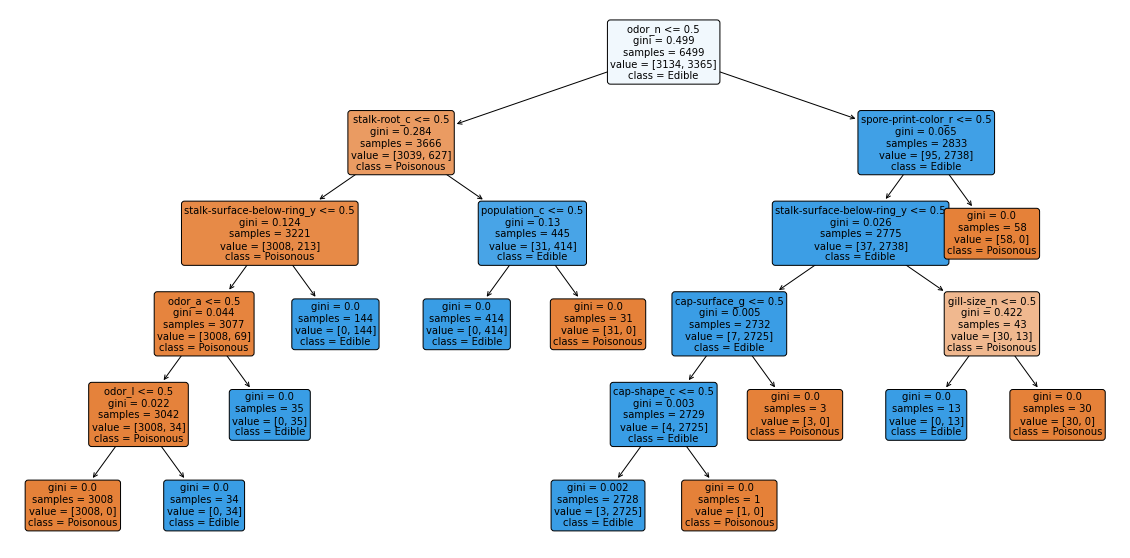

In [60]:
plot_best_tree(best_model, X.columns)

## Before You Submit...

1. Re-read the general instructions provided above, and
2. Hit "Kernel"->"Restart & Run All".